<a href="https://colab.research.google.com/github/tommyj530/DisguiseFaceRecognition/blob/main/competition_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries 

https://www.kaggle.com/purplejester/a-simple-lstm-based-time-series-classifier/data

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import sklearn
from scipy import signal
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
import torch
from torch import nn
import matplotlib.pyplot as plt


# Unzipping the dataset 

In [5]:
# train_meta contains filenames of training data and corresponding labels
from zipfile import ZipFile 
file_name = "Competition (2).zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Dataset Observation and Pre-processing

In [6]:
path = "Competition"
train_meta = pd.read_csv(path + '/train_meta.txt', delimiter = ' ', header=None, names=['filename', 'labels'])
train_meta['labels'] = train_meta['labels'].str.replace('[','')
train_meta['labels'] = train_meta['labels'].str.replace(']','')
train_meta['labels'] = train_meta.labels.apply(pd.to_numeric, errors='coerce')
train_meta['labels'] = pd.to_numeric(train_meta.labels, errors='coerce')

print(train_meta)

                   filename  labels
0     /train/GiLImBvDWs.csv       5
1     /train/VQEyZLyBMp.csv       5
2     /train/AdgWYaoORE.csv       5
3     /train/lKhsadfBkL.csv       5
4     /train/DKwGHgrHLG.csv       5
...                     ...     ...
1345  /train/KmaBQPpvuV.csv       0
1346  /train/THvCkkaZzj.csv       0
1347  /train/kqdPRRxErl.csv       0
1348  /train/XMCflmfeyQ.csv       0
1349  /train/SEHrRlwCzK.csv       0

[1350 rows x 2 columns]


Before pre-processing, let us perform the following tasks:

*   Graph the time-series data from each of the 9 channels and observe its behavhior
*   Look at the frequency properties of the time-series data: we can get a better sense of what filters to use based on its frequecny content


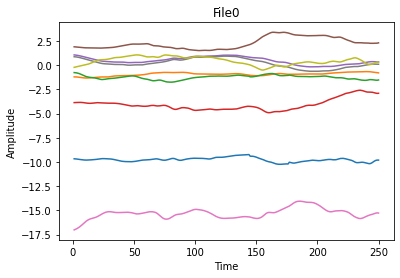

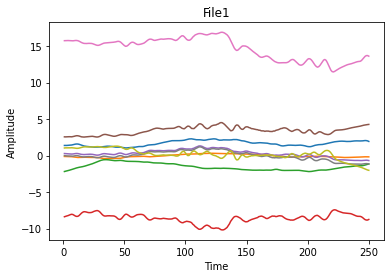

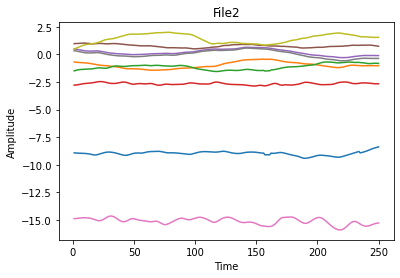

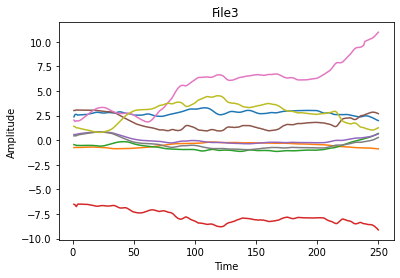

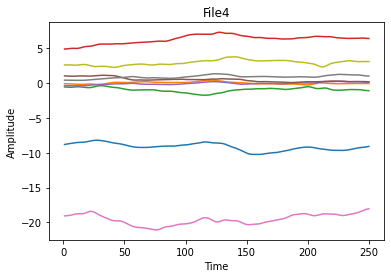

In [7]:
# check if balanced dataset
# train_meta.labels.value_counts()

# Adding data to train_meta 
# [file1], [file2], ...
num_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  num_list.append(np.transpose(temp_list))


# Visualizing the raw data for the first 5 files
for i in range(5):
  for j in range(len(num_list[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_list[i][j])
  plt.title('File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()


Let us normalize the time-series data from each channel since the model is sensitive to the actual values

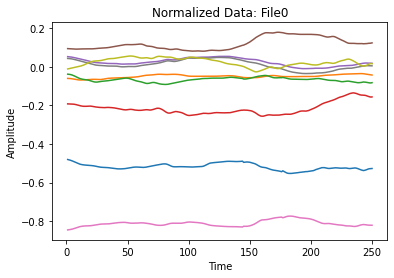

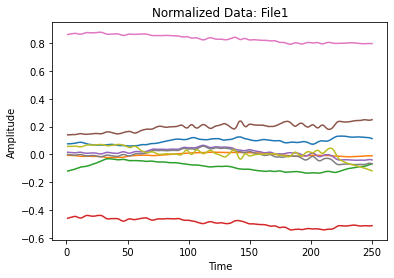

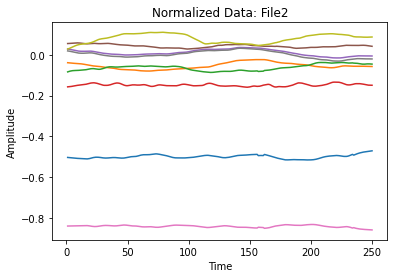

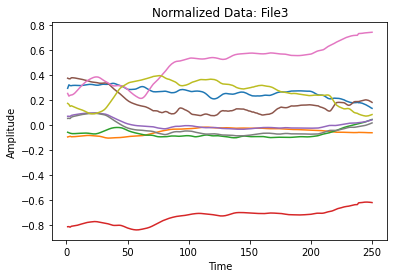

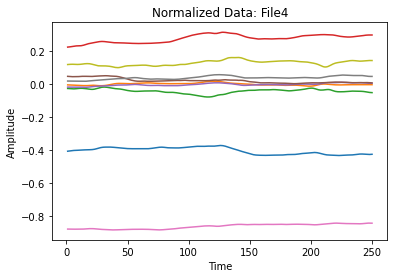

(1350, 9, 250)
1350


In [30]:
# Normalize data in each channel in each file
num_normal_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  temp_list = np.transpose(temp_list)
  temp_list = sklearn.preprocessing.normalize(temp_list, axis=0)
  num_normal_list.append(temp_list)

# Visualizing the normalized data
for i in range(5):
  for j in range(len(num_normal_list[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_normal_list[i][j])
  plt.title('Normalized Data: File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()

train_meta['features'] = num_normal_list
print(len(train_meta.features))

Frequnecy Response of the raw data
*   Based on frequency analysis, the raw data is quite clean. Just put it through a LPF


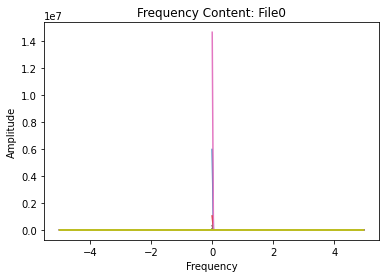

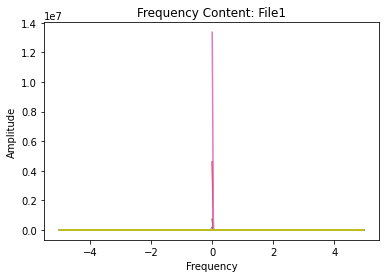

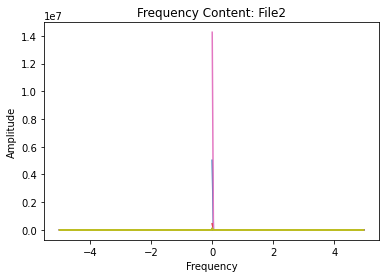

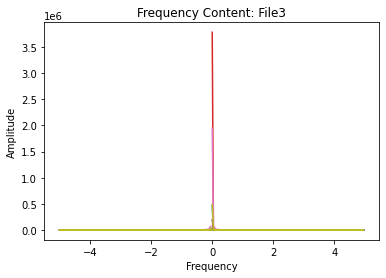

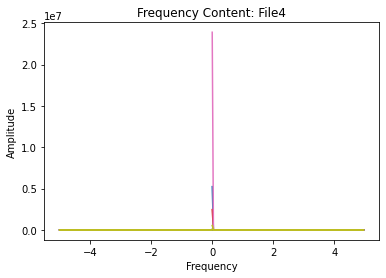

In [9]:
# FFT of the time-series data 

# for a single time-series data
'''
i = '/train/GiLImBvDWs.csv'
temp_list = np.genfromtxt(path + i)
temp_list = np.transpose(temp_list)
temp_list = np.fft.fft(temp_list)
xf = np.fft.fftfreq(temp_list.shape[1],d=1)
plt.plot(xf,temp_list[6])
plt.title('Frequency Content')
plt.xlabel('Freq') 
plt.ylabel('Amplitude') 
plt.show()

print(temp_list.shape[1])
'''

# looping for visualize others
num_fft_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  temp_list = np.transpose(temp_list)
  temp_list = np.fft.fft(temp_list, axis=1)
  num_fft_list.append(temp_list)

# Visualizing the frequency content
for i in range(5):
  for j in range(len(num_fft_list[1])):
    xf = np.fft.fftfreq(temp_list.shape[1],d=0.1)
    plt.plot(xf, np.abs(num_fft_list[i][j])**2)
  plt.title('Frequency Content: File' + str(i))
  plt.xlabel('Frequency') 
  plt.ylabel('Amplitude') 
  plt.show()

Butterworth LPF to remove noise

In [ ]:
SAMPLING_FREQUENCY = 1000
BUTTERWORTH_ORDER = 4
BANDPASS_LOW_CUTTING_FREQUENCY = 20
BANDPASS_HIGH_CUTTING_FREQUENCY = 490


def butterworth_filter(data_column):
    nyq = 0.5 * SAMPLING_FREQUENCY
    normal_low_cutoff = BANDPASS_LOW_CUTTING_FREQUENCY / nyq
    normal_high_cutoff = BANDPASS_HIGH_CUTTING_FREQUENCY / nyq

    b, a = signal.butter(BUTTERWORTH_ORDER, [normal_low_cutoff, normal_high_cutoff], 'bandpass', analog=False)
    filtered = signal.filtfilt(b, a, data_column)
    return filtered

filtered_values = []

for val in train_meta.means:
    filtered_values.append(butterworth_filter(val))

plt.plot(x_axis, butterworth_filter(filtered_values[155]), label = 'filtered')


plt.plot(x_axis, train_meta.means[155], label = 'unfiltered')
plt.legend()

AttributeError: ignored

PCA for dimensionality reduction


[6.21602885e-01 2.50300878e-01 8.56650297e-02 1.69430750e-02
 1.35605213e-02 6.06736600e-03 3.91270951e-03 1.73118708e-03
 2.16348042e-04]
(1350, 1, 250)


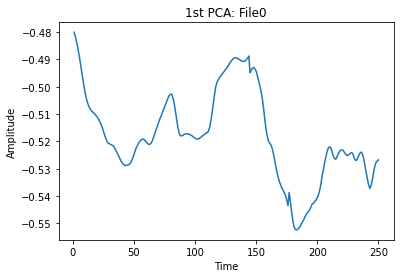

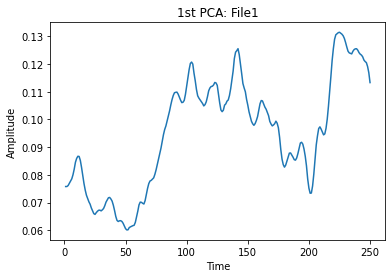

In [36]:
from sklearn.decomposition import PCA

pca = PCA()
PrincipalComponents = []
for i in range(len(train_meta.features)):
  temp_list = pca.fit_transform(np.transpose(train_meta.features[i]))
  PrincipalComponents.append(temp_list)

# Distribution of variance along principal components
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
# 62%, 25%, 8% of total variance in the data lie in 1st, 2nd, and 3rd principal componenets 
# reduce the dimensionality by 3 or more 

# Checking the size of PrinicpalComponents array 
PrincipalComponents = np.array(PrincipalComponents)
#print(PrincipalComponents.shape)

# Let us use just the first principal component and see how the model performs
pca = PCA(n_components=1)
FirstPCs = []
for i in range(len(train_meta.features)):
  temp_list = pca.fit_transform(np.transpose(train_meta.features[i]))
  FirstPCs.append(np.transpose(temp_list))

# I want the data to be structed as follows:
# [file1] [file2]
# [[PCA1],[PCA2]]
# data structure before PCA
#(1350, 9, 250)

# Checking the size: only 1st PC should be there
FirstPCs = np.array(FirstPCs)
print(FirstPCs.shape)


for i in range(2):
  for j in range(len(FirstPCs[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_normal_list[i][j])
  plt.title('1st PCA: File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()

In [2]:
def create_datasets(X, y, test_size=0.2):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

SyntaxError: ignored

# LSTM

In [70]:
# Imports
import torchvision
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 1350
sequence_length = 1
num_layers = 2
hidden_size = 256
num_classes = 14
learning_rate = 0.001
batch_size = 64
num_epochs = 2

# Create a bidirectional LSTM
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

targets = np.array(train_meta.labels)
X_train, X_valid, y_train, y_valid = train_test_split(FirstPCs, targets, test_size=0.1)
X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True)

# Initialize network
model = BRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

# Check accuracy on training & test to see how good our model

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy  \
              {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

RuntimeError: ignored

Pre-processing and Feature Extraction

In [ ]:
# Possible features: rms, mean, max, min, med, skew, kurt, std, iqr, max_energy_freq, mean_freq, median_freq, waveform_length, zero_crossing

means = []

for i in train_meta.features:
    temp_means = []
    for k in i:
        temp_means.append(np.mean(k))
    means.append(temp_means)

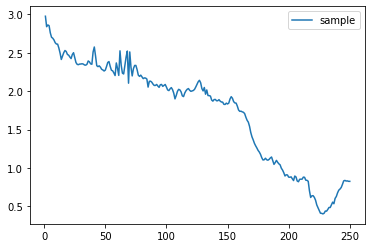

In [ ]:
x_axis = list(range(1,251))
plt.plot(x_axis, train_meta.means[155], label = 'sample')
plt.legend()

# Defining filter (preprocessing, unused)

# Convert training data to numpy array

In [ ]:
list_train_meta_means = []
for i in train_meta.means:  # change to train_meta.means for unfiltered data
    list_train_meta_means.append(i)

np_train_meta = np.array(list_train_meta_means)
np_train_meta.shape

(1350, 250)

# Normalize feature values (Note: Performance drops after doing this with XGBoost)

In [ ]:
# normalized

row_sums = np.linalg.norm(np_train_meta, axis=1)
new_matrix = np_train_meta / row_sums[:, np.newaxis]
new_matrix.shape
labels = np.array(train_meta.labels)


# Hyperparameter search

In [ ]:
gsc = GridSearchCV(
            estimator=XGBClassifier(),
            param_grid={"n_estimators": [50, 100],
                        "learning_rate": (0.05, 0.10, 0.20, 0.30, 0.40, 0.50),
                        "max_depth": [ 3, 5, 10],
                        "min_child_weight": [ 3, 5, 9],
                        "gamma":[ 0.0, 0.3, 0.5],
                        "colsample_bytree":[ 0.3, 0.5],},
            cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

gsc.fit(new_matrix, labels)
print(new_matrix.shape, labels.shape)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 118.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 190.7min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 209.9min finished


(1350, 250) (1350,)


# Cross validation metrics

In [ ]:
model = XGBClassifier()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)
 
scoring=('accuracy')
cv_results = cross_validate(model, np_train_meta, labels, cv=kf, scoring=scoring, return_train_score=False)

np.mean(cv_results['test_score'])

torch_train = torch.from_numpy(np_train_meta)
torch_labels = torch.from_numpy(labels)

torch_labels_inc = torch_labels+1

len(np.unique(np.asarray(torch_labels_inc)))